In [46]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
# Load data
data = pd.read_csv('data/data.csv', sep=';', parse_dates=['utc_time'])
ports = pd.read_csv('data/ports.csv', sep=';')


In [48]:
print(f"Missing percentage: {data.isnull().mean() * 100}")

Missing percentage: utc_time           0.000000
Latitude           0.657827
Longitude          0.657827
SpeedOverGround    0.660410
dtype: float64


In [ ]:
# Clean data
data = data.dropna(subset=['Latitude', 'Longitude', 'SpeedOverGround'])

# Sort data by time
data = data.sort_values('utc_time').reset_index(drop=True)


Missing percentage: utc_time           0.0
Latitude           0.0
Longitude          0.0
SpeedOverGround    0.0
dtype: float64


In [3]:


# Parameters
SOG_THRESHOLD = 0.5  # knots
DISTANCE_THRESHOLD = 50  # km
MIN_DURATION = pd.Timedelta(minutes=30)

# Create KDTree for ports
port_coords = ports[['Latitude', 'Longitude']].values
tree = cKDTree(np.radians(port_coords))

# Find nearest port for each data point
data_coords = np.radians(data[['Latitude', 'Longitude']].values)
distances, indices = tree.query(data_coords, k=1)
data['nearest_port_index'] = indices
data['nearest_port'] = ports['PortName'].iloc[indices].values
data['distance_to_nearest_port_km'] = data.apply(
    lambda row: geodesic((row['Latitude'], row['Longitude']), port_coords[row['nearest_port_index']]).km,
    axis=1
)

# Mark stationary and near-port points
data['is_stationary'] = data['SpeedOverGround'] < SOG_THRESHOLD
data['is_near_port'] = data['distance_to_nearest_port_km'] <= DISTANCE_THRESHOLD

# Group consecutive stationary points near the same port
data['group'] = (
    (data['is_stationary'] != data['is_stationary'].shift()) |
    (data['nearest_port'] != data['nearest_port'].shift())
).cumsum()

# Identify port calls
stationary_groups = data[data['is_stationary'] & data['is_near_port']].groupby('group')
port_calls = []
for group_id, group in stationary_groups:
    start_time = group['utc_time'].min()
    end_time = group['utc_time'].max()
    duration = end_time - start_time
    if duration >= MIN_DURATION:
        port_name = group['nearest_port'].iloc[0]
        port_calls.append({
            'port': port_name,
            'start_time': start_time,
            'end_time': end_time,
            'duration': duration
        })

port_calls_df = pd.DataFrame(port_calls)
port_calls_df.head()

,port,start_time,end_time,duration
0,Santa Cruz de Tenerife,2021-11-01 00:00:00,2021-11-01 01:24:00,0 days 01:24:00
1,Santa Cruz de Tenerife,2021-11-01 01:30:00,2021-11-01 03:00:00,0 days 01:30:00
2,Santa Cruz de Tenerife,2021-11-01 04:09:00,2021-11-01 09:21:00,0 days 05:12:00
3,Santa Cruz de Tenerife,2021-11-01 10:42:00,2021-11-01 16:24:00,0 days 05:42:00
4,Santa Cruz de Tenerife,2021-11-01 17:51:00,2021-11-01 19:21:00,0 days 01:30:00


In [5]:
unique_ports = port_calls_df['port'].unique()
print("Ports called by the ship:", unique_ports.tolist())
len(unique_ports)

Ports called by the ship: ['Santa Cruz de Tenerife', 'Brest', 'Rotterdam', 'IJmuiden', 'Hamburg', 'Kristiansand', 'Oslo', 'Zeebrugge', 'La Coruna', 'Lisbon', 'Barcelona', 'Las Palmas, Gran Canaria', 'Funchal, Madeira', 'Puerto del Rosario, Fuerteventura', 'Arrecife, Lanzarote', 'Cherbourg', 'Haugesund', 'Alesund', 'Nordfjordeid', 'Copenhagen', 'Kiel', 'Skagen', 'Stavanger', 'Flam', 'Bergen', 'Olden']


26

In [6]:
# Calculate time intervals between consecutive points
data['time_interval'] = data['utc_time'].diff().shift(-1).dt.total_seconds() / 60  # in minutes

# Total sailing time where SOG >= 0.5 knots
sailing_time = data[data['SpeedOverGround'] >= SOG_THRESHOLD]['time_interval'].sum()
print(f"Total sailing time: {sailing_time:.2f} minutes")

Total sailing time: 174957.00 minutes


In [8]:
# Function to calculate distance between consecutive points
def calculate_distance(row1, row2):
    coord1 = (row1['Latitude'], row1['Longitude'])
    coord2 = (row2['Latitude'], row2['Longitude'])
    return geodesic(coord1, coord2).km

# Calculate distances
distances = []
for i in range(len(data) - 1):
    dist = calculate_distance(data.iloc[i], data.iloc[i + 1])
    distances.append(dist)
distances.append(np.nan)  # Last row has no next point
data['distance_km'] = distances

# Total distance sailed where SOG >= 0.5 knots
total_distance_km = data[data['SpeedOverGround'] >= SOG_THRESHOLD]['distance_km'].sum()
total_distance_nm = total_distance_km * 0.539957  # 1 km ≈ 0.539957 nautical miles

#  Display result
print(f"Total distance sailed: {total_distance_km:.2f} km (~{total_distance_nm:.2f} nautical miles)")


Total distance sailed: 62300.97 km (~33639.84 nautical miles)


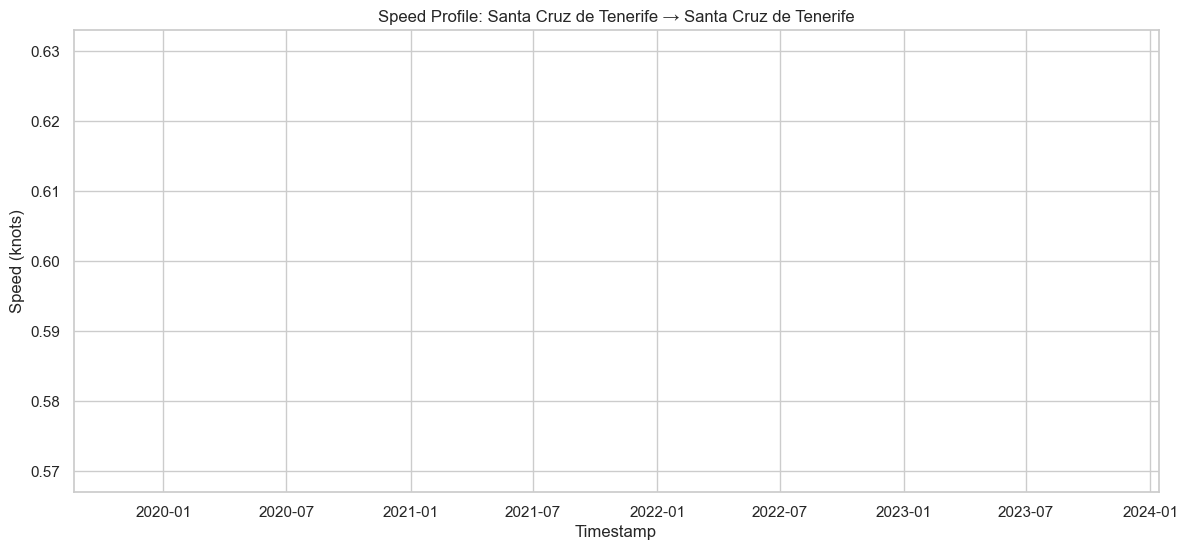

In [53]:
segment = data[(data['utc_time'] > port_calls_df.iloc[0]['end_time']) & 
               (data['utc_time'] < port_calls_df.iloc[1]['start_time'])]
plt.figure(figsize=(14, 6))
plt.plot(segment['utc_time'], segment['SpeedOverGround'], color='blue', alpha=0.7)
plt.title(f"Speed Profile: {port_calls_df.iloc[0]['port']} → {port_calls_df.iloc[1]['port']}")
plt.xlabel('Timestamp')
plt.ylabel('Speed (knots)')
plt.grid(True)
plt.show()

In [9]:
total_time_per_port = port_calls_df.groupby('port')['duration'].sum().dt.total_seconds() / 3600  # Convert to hours
print("Total time spent in each port (hours):")
print(total_time_per_port)

Total time spent in each port (hours):
port
Alesund                               36.15
Arrecife, Lanzarote                  273.00
Barcelona                             13.80
Bergen                                 8.80
Brest                                225.00
Cherbourg                             11.00
Copenhagen                            44.25
Flam                                   9.65
Funchal, Madeira                     258.10
Hamburg                               86.80
Haugesund                             39.65
IJmuiden                             191.65
Kiel                                  89.20
Kristiansand                          49.35
La Coruna                             22.85
Las Palmas, Gran Canaria             341.75
Lisbon                               151.35
Nordfjordeid                          35.25
Olden                                  9.95
Oslo                                  96.70
Puerto del Rosario, Fuerteventura    163.70
Rotterdam                       

In [14]:
total_time_per_port = port_calls_df.groupby('port')['duration'].sum()

# Sort by total duration descending
total_time_per_port = total_time_per_port.sort_values(ascending=False)

# Convert to hours and minutes (no line breaks, fixed spacing)
def format_duration(td):
    total_minutes = int(td.total_seconds() // 60)
    hours = total_minutes // 60
    minutes = total_minutes % 60
    return f"{hours:>3} hours   {minutes:>2} minutes"

formatted_time = total_time_per_port.apply(format_duration)

# Dynamically determine the max width of port names
max_port_name_length = max(len(port) for port in formatted_time.index)

print("Total time spent in each port:\n")
for port, duration in formatted_time.items():
    print(f"{port:<{max_port_name_length}}   {duration}")


Total time spent in each port:

Santa Cruz de Tenerife              479 hours   27 minutes
Las Palmas, Gran Canaria            341 hours   45 minutes
Arrecife, Lanzarote                 273 hours    0 minutes
Funchal, Madeira                    258 hours    6 minutes
Brest                               225 hours    0 minutes
IJmuiden                            191 hours   39 minutes
Puerto del Rosario, Fuerteventura   163 hours   42 minutes
Lisbon                              151 hours   21 minutes
Oslo                                 96 hours   42 minutes
Kiel                                 89 hours   12 minutes
Hamburg                              86 hours   48 minutes
Rotterdam                            64 hours   27 minutes
Kristiansand                         49 hours   21 minutes
Skagen                               46 hours    0 minutes
Copenhagen                           44 hours   15 minutes
Haugesund                            39 hours   39 minutes
Alesund                 

In [10]:
port_call_counts = port_calls_df['port'].value_counts()
print("Number of calls per port:")
print(port_call_counts)

Number of calls per port:
port
Santa Cruz de Tenerife               120
IJmuiden                              53
Las Palmas, Gran Canaria              15
Arrecife, Lanzarote                   14
Funchal, Madeira                      14
Puerto del Rosario, Fuerteventura     14
Kiel                                   7
Skagen                                 6
Oslo                                   5
Hamburg                                5
Copenhagen                             5
Nordfjordeid                           4
Haugesund                              4
Kristiansand                           4
Rotterdam                              3
Alesund                                3
Lisbon                                 3
La Coruna                              2
Stavanger                              2
Brest                                  1
Cherbourg                              1
Zeebrugge                              1
Barcelona                              1
Flam                      

In [15]:
# Identify sailing segments
port_calls_df = port_calls_df.sort_values('start_time')
sailing_segments = []
for i in range(len(port_calls_df) - 1):
    end_prev = port_calls_df.iloc[i]['end_time']
    start_next = port_calls_df.iloc[i + 1]['start_time']
    if end_prev < start_next:
        sailing_segments.append((end_prev, start_next))

# Include start and end of data if applicable
if data['utc_time'].min() < port_calls_df['start_time'].min():
    sailing_segments.insert(0, (data['utc_time'].min(), port_calls_df.iloc[0]['start_time']))
if data['utc_time'].max() > port_calls_df['end_time'].max():
    sailing_segments.append((port_calls_df.iloc[-1]['end_time'], data['utc_time'].max()))

# Calculate average speeds
average_speeds = []
for start, end in sailing_segments:
    segment_data = data[(data['utc_time'] > start) & (data['utc_time'] < end)]
    if len(segment_data) > 1:
        segment_distances = [calculate_distance(segment_data.iloc[j], segment_data.iloc[j + 1]) 
                             for j in range(len(segment_data) - 1)]
        total_distance = sum(segment_distances)
        total_time_hours = (segment_data['utc_time'].iloc[-1] - segment_data['utc_time'].iloc[0]).total_seconds() / 3600
        if total_time_hours > 0:
            avg_speed_knots = (total_distance / total_time_hours) / 1.852  # km/h to knots
            average_speeds.append(avg_speed_knots)

highest_avg_speed = max(average_speeds) if average_speeds else 0
print(f"Highest average speed between two ports: {highest_avg_speed:.2f} knots")

Highest average speed between two ports: 17.23 knots


In [17]:
data['SpeedOverGround'].max()

22.0

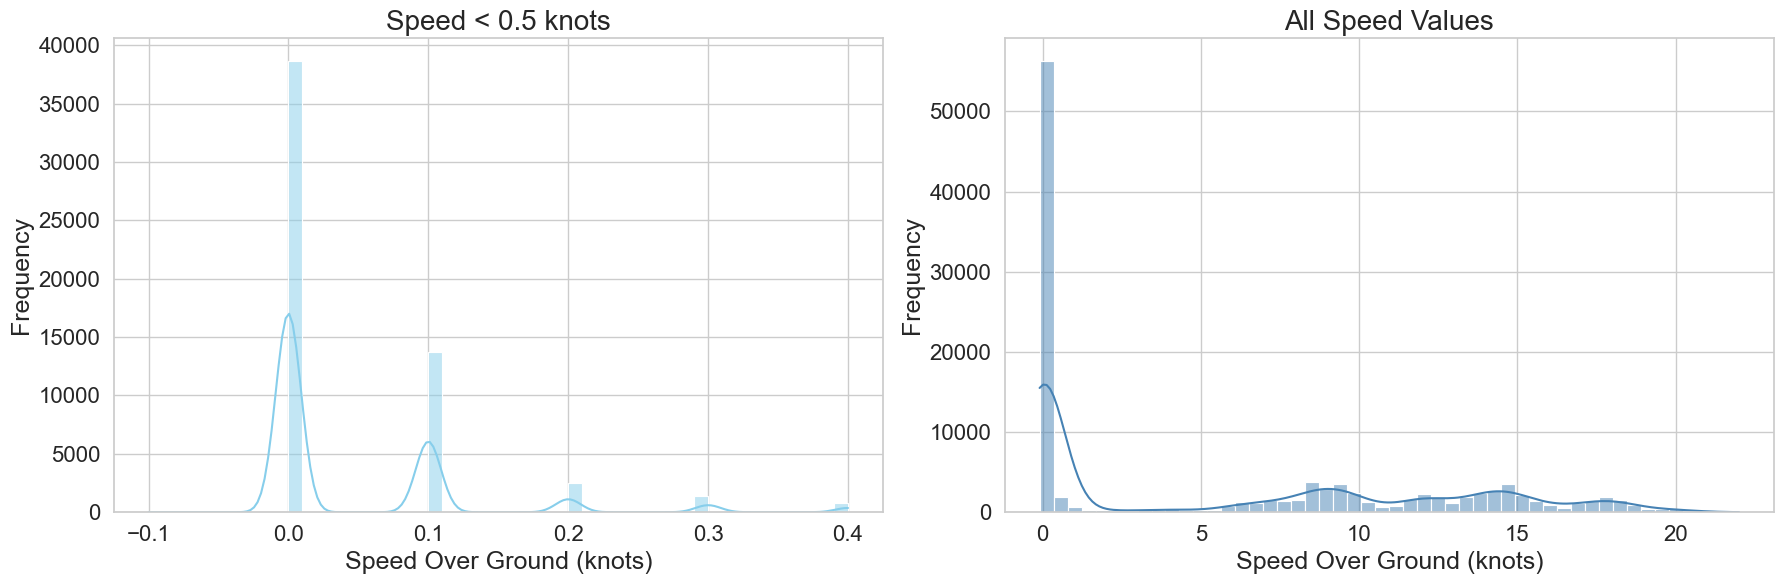

In [25]:

# Set a nice style
sns.set(style="whitegrid")

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram for speeds less than 0.5 knots (zoomed in on low speeds)
sns.histplot(data[data['SpeedOverGround'] < 0.5]['SpeedOverGround'], 
             bins=50, kde=True, color='skyblue', ax=axes[0])
axes[0].set_title('Speed < 0.5 knots', fontsize=20)
axes[0].set_xlabel('Speed Over Ground (knots)', fontsize=18)
axes[0].set_ylabel('Frequency', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)  # ← increase tick label size

# Histogram for all speeds
sns.histplot(data['SpeedOverGround'], 
             bins=50, kde=True, color='steelblue', ax=axes[1])
axes[1].set_title('All Speed Values', fontsize=20)
axes[1].set_xlabel('Speed Over Ground (knots)', fontsize=18)
axes[1].set_ylabel('Frequency', fontsize=18)
axes[1].tick_params(axis='both', labelsize=16)  # ← increase tick label size

# Adjust spacing between plots
plt.tight_layout()

# Show the plots
plt.show()

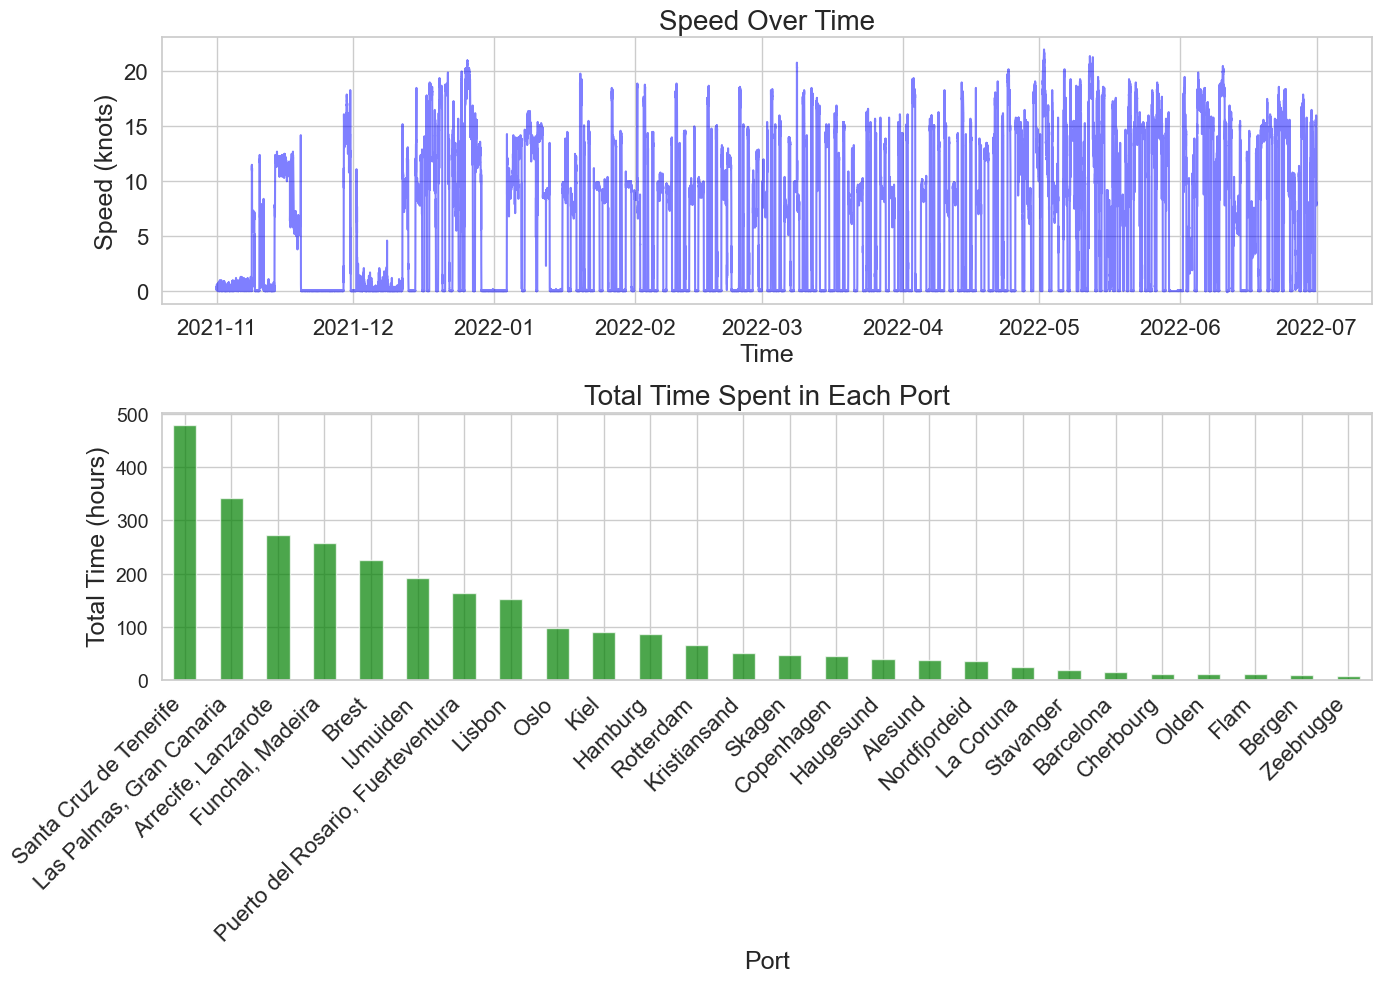

Average speed: 5.86 knots
Total sailing segments: 290


In [28]:
import matplotlib.pyplot as plt

# Create a 2-row, 1-column subplot
fig, axes = plt.subplots(2, 1, figsize=(14, 10))  # wider and taller for better spacing

# Plot 1: Speed over time
axes[0].plot(data['utc_time'], data['SpeedOverGround'], color='blue', alpha=0.5)
axes[0].set_title('Speed Over Time', fontsize=20)  # Title font size set to 20
axes[0].set_xlabel('Time', fontsize=18)  # X label font size set to 18
axes[0].set_ylabel('Speed (knots)', fontsize=18)  # Y label font size set to 18
axes[0].grid(True)
axes[0].tick_params(axis='both', labelsize=16)  # Tick labels font size set to 16

# Plot 2: Bar chart of total time per port (in hours)
total_time_hours = total_time_per_port.dt.total_seconds() / 3600  # ensure bar chart uses numeric values
total_time_hours.sort_values(ascending=False).plot(
    kind='bar',
    ax=axes[1],
    color='green',
    alpha=0.7
)
axes[1].set_title('Total Time Spent in Each Port', fontsize=20)  # Title font size set to 20
axes[1].set_xlabel('Port', fontsize=18)  # X label font size set to 18
axes[1].set_ylabel('Total Time (hours)', fontsize=18)  # Y label font size set to 18
axes[1].tick_params(axis='y', labelsize=14)  # Y ticks font size set to 14

# Adjust X ticks to prevent overlap
axes[1].tick_params(axis='x', labelsize=16)  # X ticks font size set to 16
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")  # Adjust rotation and alignment

# Tight layout to ensure everything fits without overlap
plt.tight_layout()
plt.show()

# Statistics
print(f"Average speed: {data['SpeedOverGround'].mean():.2f} knots")
print(f"Total sailing segments: {len(sailing_segments)}")


In [34]:
def format_duration(td):
    total_minutes = int(td.total_seconds() // 60)
    days = td.days
    hours = (total_minutes // 60) % 24
    minutes = total_minutes % 60
    return f"{days} days {hours:02d} hours and {minutes:02d} minutes"

longest_call = port_calls_df.loc[port_calls_df['duration'].idxmax()]
shortest_call = port_calls_df.loc[port_calls_df['duration'].idxmin()]

print(f"Longest port call: {longest_call['port']} with duration of {format_duration(longest_call['duration'])}")
print(f"Shortest port call: {shortest_call['port']} with duration of {format_duration(shortest_call['duration'])}")


Longest port call: Brest with duration of 9 days 09 hours and 00 minutes
Shortest port call: Santa Cruz de Tenerife with duration of 0 days 00 hours and 30 minutes


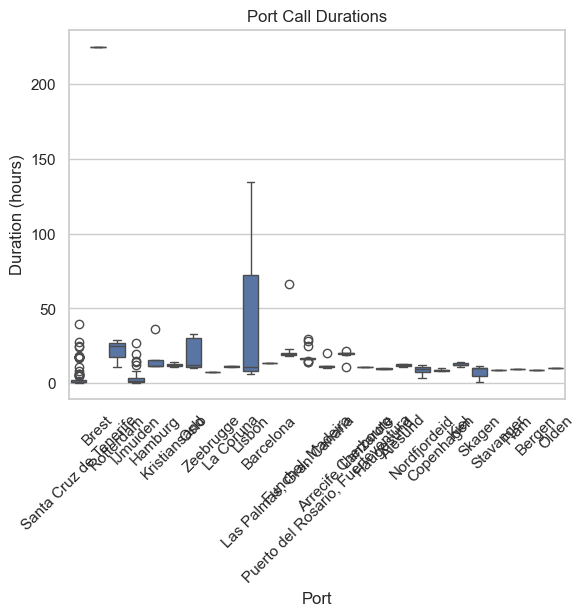

In [35]:
# Box plot of port call durations
port_calls_df['duration_hours'] = port_calls_df['duration'].dt.total_seconds() / 3600
sns.boxplot(x='port', y='duration_hours', data=port_calls_df)
plt.title('Port Call Durations')
plt.xlabel('Port')
plt.ylabel('Duration (hours)')
plt.xticks(rotation=45)
plt.show()

In [41]:
port1 = ports.iloc[0]  # e.g., Aalborg
port2 = ports.iloc[1]  # e.g., Aarhus
distance_km = geodesic((port1['Latitude'], port1['Longitude']), 
                    (port2['Latitude'], port2['Longitude'])).km
# Convert to nautical miles
distance_nm = distance_km / 1.852

print(f"Distance between {port1['PortName']} and {port2['PortName']}: {distance_km:.2f} km ({distance_nm:.2f} nautical miles)")


Distance between Aalborg and Aarhus: 101.03 km (54.55 nautical miles)


In [42]:
def power_demand(v):
    return 6.874 * v**3 - 83.274 * v**2 + 659.5 * v + 9010

data['time_interval_hours'] = data['time_interval'] / 60
data['power'] = data['SpeedOverGround'].apply(power_demand)
data['energy'] = data['power'] * data['time_interval_hours']
total_energy = data[data['SpeedOverGround'] >= SOG_THRESHOLD]['energy'].sum()
print(f"Total energy consumed during sailing time: {total_energy:.2f} kWh")

Total energy consumed during sailing time: 55375059.06 kWh


Explanation:

Computed Speed: Distance/time, converted to knots.

Comparison: Analyzes differences and correlation, with a histogram to visualize discrepancies.

Insights: Small mean/std and high correlation suggest good signal quality.

Mean difference: 0.02 knots
Std deviation: 0.64 knots
Correlation: 1.00


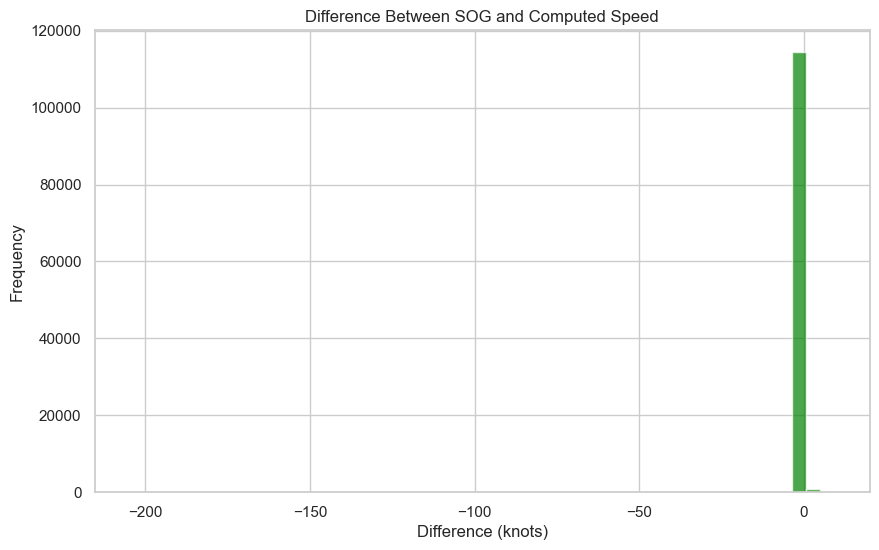

In [43]:
data['computed_speed'] = data['distance_km'] / (data['time_interval'] / 60)  # km/h
data['computed_speed_knots'] = data['computed_speed'] / 1.852
data['speed_difference'] = data['SpeedOverGround'] - data['computed_speed_knots']

# Statistics
print(f"Mean difference: {data['speed_difference'].mean():.2f} knots")
print(f"Std deviation: {data['speed_difference'].std():.2f} knots")
print(f"Correlation: {data['SpeedOverGround'].corr(data['computed_speed_knots']):.2f}")

# Plot
plt.figure(figsize=(10, 6))
plt.hist(data['speed_difference'].dropna(), bins=50, color='green', alpha=0.7)
plt.title('Difference Between SOG and Computed Speed')
plt.xlabel('Difference (knots)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import interp1d

# Step 1: Load and prepare the AIS data
data = pd.read_csv('data/data.csv', sep=';', parse_dates=['utc_time'])  # Replace with your file path
data = data.sort_values('utc_time')
start_time = data['utc_time'].min()
data['time_since_start'] = (data['utc_time'] - start_time).dt.total_seconds()
total_time = data['time_since_start'].max()

# Step 2: Create interpolation functions for latitude and longitude
lat_interp = interp1d(data['time_since_start'], data['Latitude'], kind='linear', fill_value="extrapolate")
lon_interp = interp1d(data['time_since_start'], data['Longitude'], kind='linear', fill_value="extrapolate")

# Step 3: Set up the map with Cartopy
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set map extent based on the journey with padding
min_lon, max_lon = data['Longitude'].min(), data['Longitude'].max()
min_lat, max_lat = data['Latitude'].min(), data['Latitude'].max()
ax.set_extent([min_lon - 5, max_lon + 5, min_lat - 5, max_lat + 5], crs=ccrs.PlateCarree())

# Plot the entire path
ax.plot(data['Longitude'], data['Latitude'], transform=ccrs.PlateCarree(), color='blue', alpha=0.5)

# Step 4: Initialize animation elements
path_line, = ax.plot([], [], color='red', transform=ccrs.PlateCarree())  # Path up to current position
marker, = ax.plot([], [], 'ro', transform=ccrs.PlateCarree())  # Ship marker
time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, ha='left', va='top')  # Timestamp

# Step 5: Define the animation update function
def update(frame):
    journey_time = (frame / total_frames) * total_time
    if journey_time > total_time:
        journey_time = total_time
    # Update path line up to current time
    past_points = data[data['time_since_start'] <= journey_time]
    path_line.set_data(past_points['Longitude'], past_points['Latitude'])
    # Update ship marker position
    lat = lat_interp(journey_time)
    lon = lon_interp(journey_time)
    marker.set_data([lon], [lat])
    # Update timestamp
    current_time = start_time + pd.Timedelta(seconds=journey_time)
    time_text.set_text(current_time.strftime('%Y-%m-%d %H:%M:%S'))
    return path_line, marker, time_text

# Step 6: Set animation parameters
video_duration = 60  # seconds
frame_rate = 30  # frames per second
total_frames = video_duration * frame_rate

# Step 7: Create and save the animation
anim = FuncAnimation(fig, update, frames=total_frames, interval=1000 / frame_rate, blit=True)
anim.save('ship_path.mp4', writer='ffmpeg')

plt.close()  # Optional: Close the figure to free memory

/Users/ap/anaconda3/envs/cleanml/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/ap/anaconda3/envs/cleanml/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/ap/anaconda3/envs/cleanml/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/ap/anaconda3/envs/cleanml/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)

In [ ]:
from moviepy.editor import VideoFileClip

# Load the original video (replace with your video file path)
original_video_path = 'ship_path.mp4'
clip = VideoFileClip(original_video_path)

# Calculate the duration of the original video in seconds (1 hour = 3600 seconds)
original_duration = clip.duration

# Desired duration of the final video in seconds (2 minutes = 120 seconds)
desired_duration = 120

# Calculate the speed factor (3600 / 120 = 30x faster)
speed_factor = original_duration / desired_duration

# Speed up the video
fast_forwarded_clip = clip.speedx(factor=speed_factor)

# Save the fast-forwarded video (replace with your desired output path)
output_video_path = 'ship_path_fast_forwarded.mp4'
fast_forwarded_clip.write_videofile(output_video_path, codec='libx264')

print(f"Fast-forwarded video saved to {output_video_path}")